In [1]:
import sqlalchemy
import pandas as pd
import numpy as np
import random
import math
import tensorflow as tf

pd.options.mode.chained_assignment = None

In [2]:
engine = sqlalchemy.create_engine('sqlite:///binance_1m_prices_1month')

# Declare Constants.

In [3]:
crypto_pairs = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'UNIUSDT']
predict_pair = 'BTCUSDT'

lookback_window = 60
shortest_predict_window = 2
longest_predict_window = 2
train_dataset_percent = 0.8

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
epochs = 3

# Define Necessary Functions.

In [4]:
def signal_labeling(df, shortest_predict_window, longest_predict_window):
    windows = list(range(shortest_predict_window, longest_predict_window + 1))
    df['signal'] = np.nan

    for i in range(df.shape[0] - windows[-1]):
        max_price_delta = 0
        max_window = 0
        present_price = df.iloc[i, 3]

        for window in windows:
            future_price = df.iloc[i + window, 3]
            price_delta = future_price - present_price

            if price_delta > max_price_delta:
                max_price_delta = price_delta
                max_window = window

        df.iloc[i, -1] = max_window
    
    df = df.astype('float32')    
    return df


In [5]:
def normalize_data(df, lookback_window):
    df[f'price_mov_avg_{lookback_window}'] = df['close'].rolling(lookback_window).mean()
    df[f'vol_mov_avg_{lookback_window}'] = df['volume'].rolling(lookback_window).mean()
    df[f'price_std_{lookback_window}'] = df['close'].rolling(lookback_window).std()
    df[f'vol_std_{lookback_window}'] = df['volume'].rolling(lookback_window).std()
    
    for column in df.columns[:5]:
        if column=='volume':
            df[column] = (df[column] - df[f'vol_mov_avg_{lookback_window}'])/df[f'vol_std_{lookback_window}']
        else:
            df[column] = (df[column] - df[f'price_mov_avg_{lookback_window}'])/df[f'price_std_{lookback_window}']
    
    df.drop(columns=[f'price_mov_avg_{lookback_window}',
                    f'vol_mov_avg_{lookback_window}',
                    f'price_std_{lookback_window}',
                    f'vol_std_{lookback_window}'], inplace=True)
    
    df = df.astype('float32')
    return df
    

In [6]:
def create_main_df():    
    main_df = pd.DataFrame()

    for pair in crypto_pairs:
        df = pd.read_sql(pair, engine, index_col='time')
        df = df.astype('float32')

        if pair==predict_pair:
            print('Labeling........')
            df = signal_labeling(df, shortest_predict_window, longest_predict_window)
            print('Labeling Completed!')

        df = normalize_data(df, lookback_window)

        df.rename(columns={'open': f'{pair}_open',
                          'high': f'{pair}_high',
                          'low': f'{pair}_low',
                          'close': f'{pair}_close',
                          'volume': f'{pair}_volume'
                          }, inplace=True)

        if len(main_df) == 0:
            main_df = df
        else:
            main_df = main_df.join(df)
    
    print("\nCreate main dataframe completed!")
    print("\nMain Dataframe shape:", main_df.shape)
    print("\nNumber of labels:", "\n", main_df['signal'].value_counts(), sep='')
    print("\nPercentage of labels:", "\n", main_df['signal'].value_counts(normalize=True), sep='')

    main_df = main_df.astype('float32')
    return main_df
    

In [7]:
def process_data_binary_labels(df):
    signal_0 = []
    signal_1 = []

    df.dropna(inplace=True)

    for i in range(len(df) - lookback_window):
        instance = df.iloc[i:i+lookback_window]

        if len(instance)==lookback_window:
            signal = instance['signal'].iloc[-1]
            instance = instance.drop(columns=['signal'])

            if signal==0: signal_0.append([instance, signal])
            elif signal!=0: signal_1.append([instance, 1])

    signal_len = [len(signal_0), len(signal_1)]
    sample_number = min(signal_len)

    signal_0 = random.sample(signal_0 , sample_number)
    signal_1 = random.sample(signal_1 , sample_number)

    processed_data = signal_0 + signal_1
    random.shuffle(processed_data)

    sequences = []
    signals =[]

    for sequence, signal in processed_data:
        sequences.append(sequence)
        signals.append(signal)

    return np.array(sequences), signals

In [8]:
def create_train_test_dataset_binary_labels():

    main_df.dropna(inplace=True)
    
    split_point = math.ceil(len(main_df) * train_dataset_percent)
    train_dataset = main_df.iloc[:split_point]
    test_dataset = main_df.iloc[split_point:]

    train_X, train_y = process_data_binary_labels(train_dataset)
    test_X, test_y = process_data_binary_labels(test_dataset)
    
    print("Train dataset length:", len(train_dataset))
    print("Test dataset length:", len(test_dataset))
    
    return train_X, train_y, test_X, test_y

In [9]:
def create_data_pipline():
    train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_X, test_y))

    train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    test_dataset = test_dataset.batch(BATCH_SIZE)
    
    return train_dataset, test_dataset

# Hyperparameters Tuning.

In [10]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [11]:
from tensorboard.plugins.hparams import api as hp

In [12]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([32, 64]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.2, 0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

In [13]:
def train_test_model(hparams, label_num=2):
    model = tf.keras.Sequential([    
        tf.keras.layers.LSTM(hparams[HP_NUM_UNITS], return_sequences=True),
        tf.keras.layers.Dropout(hparams[HP_DROPOUT]),

        tf.keras.layers.LSTM(hparams[HP_NUM_UNITS]),
        tf.keras.layers.Dropout(hparams[HP_DROPOUT]),

        tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation='relu'),
        tf.keras.layers.Dropout(hparams[HP_DROPOUT]),

        tf.keras.layers.Dense(label_num, activation='softmax')
    ])

    model.compile(
        optimizer=hparams[HP_OPTIMIZER],
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['sparse_categorical_accuracy']
    )
    
    
    model.fit(train_dataset, epochs=epochs)

    _, accuracy = model.evaluate(test_dataset)
    return accuracy

In [14]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

# Train and Test Model to Predict Buy Signal in the Next 2 Minutes.

In [15]:
shortest_predict_window = 2
longest_predict_window = 2

In [16]:
main_df = create_main_df()

Labeling........
Labeling Completed!

Create main dataframe completed!

Main Dataframe shape: (44641, 21)

Number of labels:
0.0    22468
2.0    22171
Name: signal, dtype: int64

Percentage of labels:
0.0    0.503327
2.0    0.496673
Name: signal, dtype: float64


In [17]:
main_df.tail(10)

,BTCUSDT_open,BTCUSDT_high,BTCUSDT_low,BTCUSDT_close,BTCUSDT_volume,signal,ETHUSDT_open,ETHUSDT_high,ETHUSDT_low,ETHUSDT_close,...,XRPUSDT_open,XRPUSDT_high,XRPUSDT_low,XRPUSDT_close,XRPUSDT_volume,UNIUSDT_open,UNIUSDT_high,UNIUSDT_low,UNIUSDT_close,UNIUSDT_volume
time,,,,,,,,,,,,,,,,,,,,,
1635724260000,-0.629216,-0.325984,-0.761311,-0.739075,-0.724610,0.0,-0.136201,0.143804,-0.618756,-0.574101,...,0.579396,0.968830,0.543989,0.685617,-0.202313,-0.461821,-0.207604,-0.716037,-0.461821,-0.363979
1635724320000,-0.719478,-0.719478,-1.257351,-1.257351,-0.842520,2.0,-0.542807,-0.542807,-1.043234,-0.973412,...,0.634080,0.669575,0.350164,0.385659,-0.724140,-0.426892,-0.426892,-1.195308,-0.939169,-0.127658
1635724380000,-1.232359,-0.607113,-1.254251,-1.036857,-0.192524,2.0,-0.895683,-0.289324,-0.967367,-0.625356,...,0.334020,0.618797,0.298418,0.334020,2.358586,-0.909050,-0.392052,-0.909050,-0.909050,-0.196077
1635724440000,-1.011140,-0.758039,-1.077349,-1.042686,-0.444583,2.0,-0.611472,-0.147978,-0.683471,-0.161455,...,0.281869,0.496393,0.174586,0.281869,-0.659239,-0.893472,-0.367898,-0.893472,-0.367898,-0.311272
1635724500000,-1.037220,-0.517716,-1.253803,-0.517716,0.225696,0.0,-0.215256,0.604676,-0.215256,0.564202,...,0.292993,0.758423,0.292993,0.686805,-0.631565,-0.345648,-0.079762,-0.611534,-0.345648,-0.305162
1635724560000,-0.499191,-0.427905,-0.981073,-0.980982,0.316941,0.0,0.580480,0.621079,-0.219446,-0.219446,...,0.706775,0.742719,0.203643,0.347419,-0.581303,-0.323152,-0.323152,-0.861743,-0.323152,-0.428268
1635724620000,-0.940496,-0.695235,-1.360687,-1.207596,1.011180,2.0,-0.188902,0.074530,-0.858894,-0.604608,...,0.313133,0.349061,-0.369414,-0.297558,0.044872,-0.290493,-0.290493,-1.120479,-0.567155,-0.336534
1635724680000,-1.176075,-0.894289,-1.336975,-1.158049,0.077154,2.0,-0.586589,-0.285127,-0.644428,-0.536333,...,-0.238262,-0.057767,-0.274370,-0.093875,-0.798167,-0.543738,-0.264897,-0.822579,-0.543738,-0.455816
1635724740000,-1.136457,-0.743642,-1.226801,-0.991094,0.845730,NaN,-0.524023,-0.199182,-0.615547,-0.319676,...,-0.107731,0.037534,-0.361901,-0.035098,1.372584,-0.518964,-0.235892,-0.518964,-0.518964,-0.463133


In [18]:
train_X, train_y, test_X, test_y = create_train_test_dataset_binary_labels()

Train dataset length: 35664
Test dataset length: 8916


In [19]:
train_dataset, test_dataset = create_data_pipline()

In [20]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
            hparams = {
                HP_NUM_UNITS: num_units,
                HP_DROPOUT: dropout_rate,
                HP_OPTIMIZER: optimizer,
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run('logs/hparam_tuning/' + run_name, hparams)
            session_num += 1

--- Starting trial: run-0
{'num_units': 32, 'dropout': 0.2, 'optimizer': 'adam'}
Epoch 1/3
556/556 [==============================] - 10s 18ms/step - loss: 0.6932 - sparse_categorical_accuracy: 0.5112
Epoch 2/3
556/556 [==============================] - 10s 18ms/step - loss: 0.6925 - sparse_categorical_accuracy: 0.5195
Epoch 3/3
135/135 [==============================] - 1s 6ms/step - loss: 0.6922 - sparse_categorical_accuracy: 0.5210
--- Starting trial: run-1
{'num_units': 32, 'dropout': 0.2, 'optimizer': 'sgd'}
Epoch 1/3
556/556 [==============================] - 10s 18ms/step - loss: 0.6946 - sparse_categorical_accuracy: 0.5039
Epoch 2/3
556/556 [==============================] - 10s 18ms/step - loss: 0.6936 - sparse_categorical_accuracy: 0.5078
Epoch 3/3
135/135 [==============================] - 1s 6ms/step - loss: 0.6928 - sparse_categorical_accuracy: 0.5100
--- Starting trial: run-2
{'num_units': 32, 'dropout': 0.5, 'optimizer': 'adam'}
Epoch 1/3
556/556 [=======================

In [22]:
%tensorboard --logdir logs/hparam_tuning

Reusing TensorBoard on port 6006 (pid 7600), started 0:01:22 ago. (Use '!kill 7600' to kill it.)

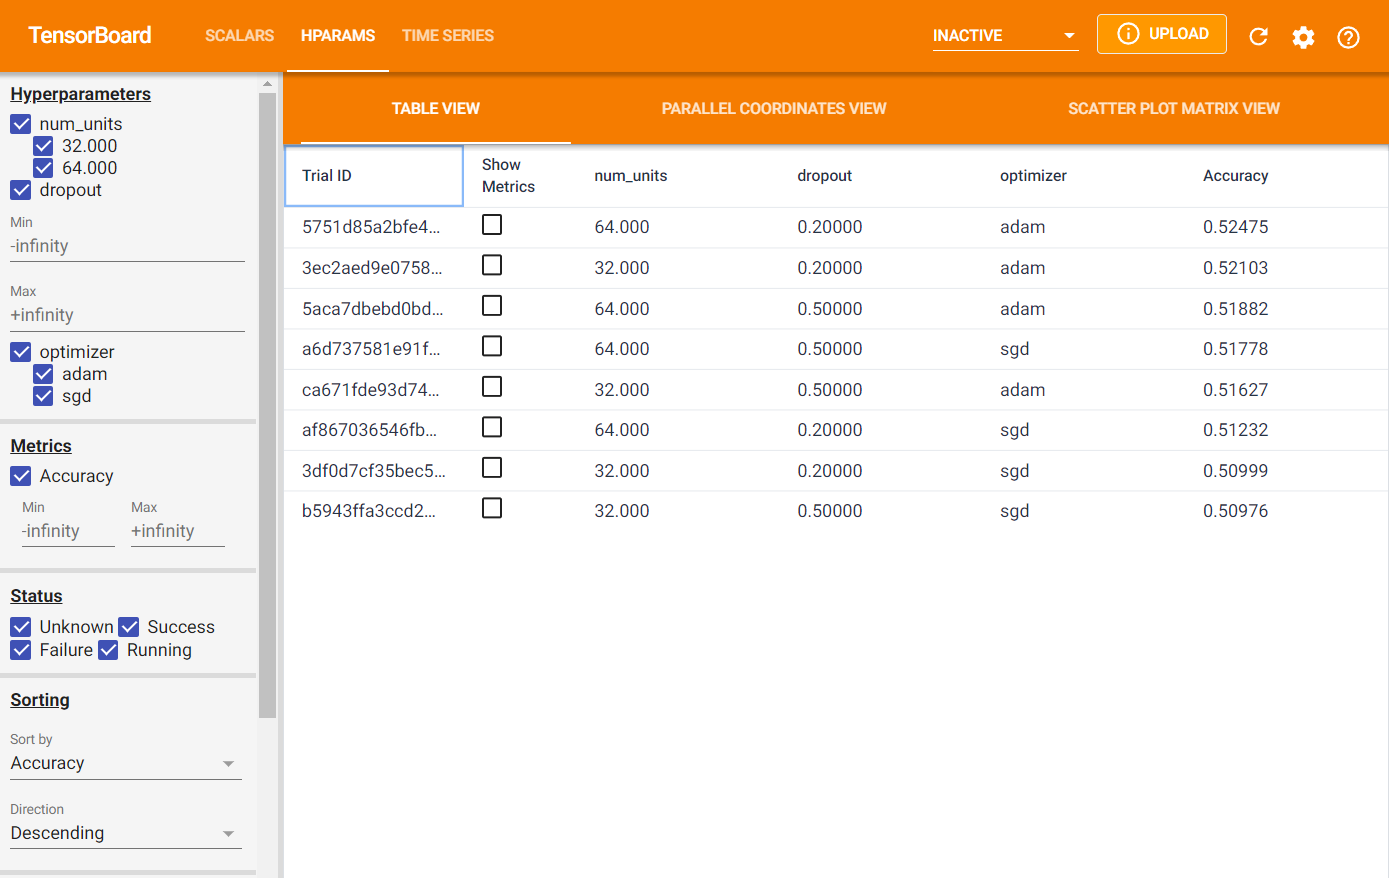

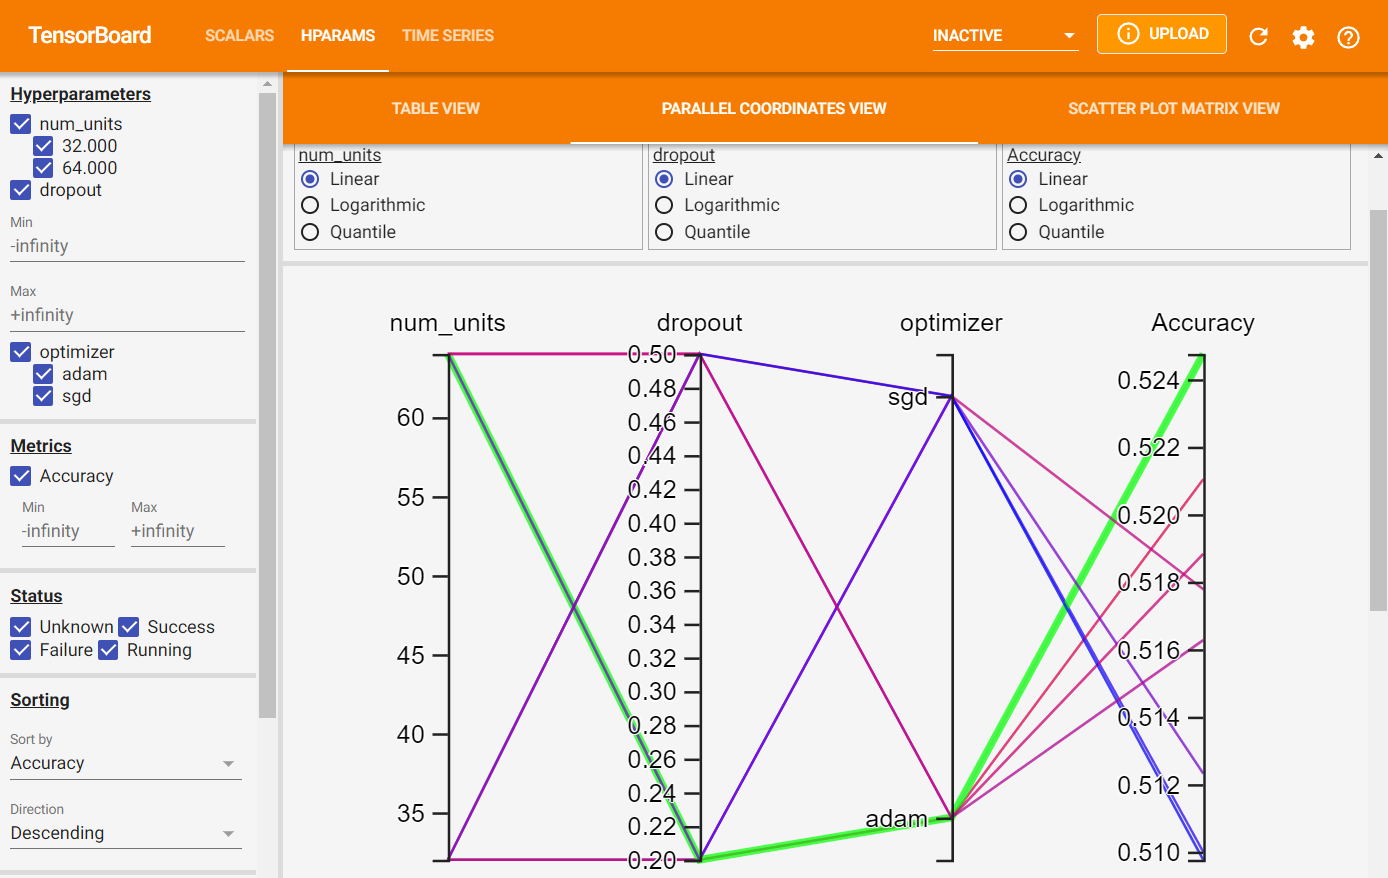

# Train and Test Model to Predict Buy Signal in Multi-Windows (From 2-5 Minutes).

taskkill /im tensorboard.exe /f
del /q %TMP%\.tensorboard-info\*

In [23]:
optimized_units = 64
optimized_dropout = 0.2
optimized_optimizer = tf.optimizers.Adam()
# optimized_optimizer = tf.keras.optimizers.SGD()


In [24]:
shortest_predict_window = 2
longest_predict_window = 5

In [25]:
def process_data_five_labels(df):
    signal_0 = []
    signal_1 = []
    signal_2 = []
    signal_3 = []
    signal_4 = []

    df.dropna(inplace=True)

    for i in range(len(df) - lookback_window):
        instance = df.iloc[i:i+lookback_window]

        if len(instance)==lookback_window:
            signal = instance['signal'].iloc[-1]
            instance = instance.drop(columns=['signal'])

            if signal==0: signal_0.append([instance, 0])
            elif signal==2: signal_1.append([instance, 1])
            elif signal==3: signal_2.append([instance, 2])
            elif signal==4: signal_3.append([instance, 3])
            else: signal_4.append([instance, 4])

    signal_len = [len(signal_0), len(signal_1), len(signal_2), len(signal_3), len(signal_4)]
    sample_number = min(signal_len)

    signal_0 = random.sample(signal_0 , sample_number)
    signal_1 = random.sample(signal_1 , sample_number)
    signal_2 = random.sample(signal_2 , sample_number)
    signal_3 = random.sample(signal_3 , sample_number)
    signal_4 = random.sample(signal_4 , sample_number)

    processed_data = signal_0 + signal_1 + signal_2 + signal_3 + signal_4
    random.shuffle(processed_data)

    sequences = []
    signals = []

    for sequence, signal in processed_data:
        sequences.append(sequence)
        signals.append(signal)

    sequences = np.array(sequences)
        
    return sequences, signals

In [26]:
def create_train_test_dataset_five_labels():

    main_df.dropna(inplace=True)
    
    split_point = math.ceil(len(main_df) * train_dataset_percent)
    train_dataset = main_df.iloc[:split_point]
    test_dataset = main_df.iloc[split_point:]

    train_X, train_y = process_data_five_labels(train_dataset)
    test_X, test_y = process_data_five_labels(test_dataset)
    
    print("Train dataset length:", len(train_dataset))
    print("Test dataset length:", len(test_dataset))
    
    return train_X, train_y, test_X, test_y

In [27]:
def train_test_model(label_num=2):
    model = tf.keras.Sequential([    
        tf.keras.layers.LSTM(optimized_units, return_sequences=True),
        tf.keras.layers.Dropout(optimized_dropout),

        tf.keras.layers.LSTM(optimized_units),
        tf.keras.layers.Dropout(optimized_dropout),

        tf.keras.layers.Dense(optimized_units, activation='relu'),
        tf.keras.layers.Dropout(optimized_dropout),

        tf.keras.layers.Dense(label_num, activation='softmax')
    ])

    model.compile(
        optimizer=optimized_optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['sparse_categorical_accuracy']
    )
        
    model.fit(train_dataset, epochs=epochs)

    model.evaluate(test_dataset)
    

In [28]:
main_df = create_main_df()

Labeling........
Labeling Completed!

Create main dataframe completed!

Main Dataframe shape: (44641, 21)

Number of labels:
0.0    13955
5.0    11378
2.0     7071
4.0     6402
3.0     5830
Name: signal, dtype: int64

Percentage of labels:
0.0    0.312640
5.0    0.254906
2.0    0.158415
4.0    0.143427
3.0    0.130612
Name: signal, dtype: float64


In [29]:
train_X, train_y, test_X, test_y = create_train_test_dataset_five_labels()

Train dataset length: 35662
Test dataset length: 8915


In [30]:
train_dataset, test_dataset = create_data_pipline()

In [31]:
train_test_model(label_num=5)

Epoch 1/3
360/360 [==============================] - 11s 32ms/step - loss: 1.6093 - sparse_categorical_accuracy: 0.2103
Epoch 2/3
360/360 [==============================] - 12s 32ms/step - loss: 1.6080 - sparse_categorical_accuracy: 0.2171
Epoch 3/3
94/94 [==============================] - 1s 13ms/step - loss: 1.6078 - sparse_categorical_accuracy: 0.2120


# Train and Test Model to Predict ETH Price.

### Single step: in the next 2 minutes.

In [32]:
predict_pair = 'ETHUSDT'
shortest_predict_window = 2
longest_predict_window = 2


In [33]:
main_df = create_main_df()
train_X, train_y, test_X, test_y = create_train_test_dataset_binary_labels()
train_dataset, test_dataset = create_data_pipline()
train_test_model(label_num=2)

Labeling........
Labeling Completed!

Create main dataframe completed!

Main Dataframe shape: (44641, 21)

Number of labels:
2.0    22435
0.0    22204
Name: signal, dtype: int64

Percentage of labels:
2.0    0.502587
0.0    0.497413
Name: signal, dtype: float64
Train dataset length: 35664
Test dataset length: 8916
Epoch 1/3
553/553 [==============================] - 18s 32ms/step - loss: 0.6945 - sparse_categorical_accuracy: 0.5064
Epoch 2/3
553/553 [==============================] - 17s 31ms/step - loss: 0.6928 - sparse_categorical_accuracy: 0.5142
Epoch 3/3
139/139 [==============================] - 2s 13ms/step - loss: 0.6935 - sparse_categorical_accuracy: 0.5080


### Combining various single step: in the next 2, 3, 4, and 5 minutes.

In [34]:
shortest_predict_window = 2
longest_predict_window = 5

main_df = create_main_df()
train_X, train_y, test_X, test_y = create_train_test_dataset_five_labels()
train_dataset, test_dataset = create_data_pipline()
train_test_model(label_num=5)

Labeling........
Labeling Completed!

Create main dataframe completed!

Main Dataframe shape: (44641, 21)

Number of labels:
0.0    13616
5.0    11652
2.0     7094
4.0     6460
3.0     5814
Name: signal, dtype: int64

Percentage of labels:
0.0    0.305045
5.0    0.261045
2.0    0.158930
4.0    0.144726
3.0    0.130254
Name: signal, dtype: float64
Train dataset length: 35662
Test dataset length: 8915
Epoch 1/3
362/362 [==============================] - 12s 32ms/step - loss: 1.6096 - sparse_categorical_accuracy: 0.2105
Epoch 2/3
362/362 [==============================] - 12s 33ms/step - loss: 1.6080 - sparse_categorical_accuracy: 0.2140
Epoch 3/3
91/91 [==============================] - 1s 13ms/step - loss: 1.6116 - sparse_categorical_accuracy: 0.1964


# Train and Test Model to Predict XPR Price.

### Single step: in the next 2 minutes.

In [35]:
predict_pair = 'XRPUSDT'
shortest_predict_window = 2
longest_predict_window = 2


In [36]:
main_df = create_main_df()
train_X, train_y, test_X, test_y = create_train_test_dataset_binary_labels()
train_dataset, test_dataset = create_data_pipline()
train_test_model(label_num=2)

Labeling........
Labeling Completed!

Create main dataframe completed!

Main Dataframe shape: (44641, 21)

Number of labels:
0.0    22948
2.0    21691
Name: signal, dtype: int64

Percentage of labels:
0.0    0.51408
2.0    0.48592
Name: signal, dtype: float64
Train dataset length: 35664
Test dataset length: 8916
Epoch 1/3
539/539 [==============================] - 18s 33ms/step - loss: 0.6935 - sparse_categorical_accuracy: 0.5065
Epoch 2/3
539/539 [==============================] - 17s 32ms/step - loss: 0.6926 - sparse_categorical_accuracy: 0.5138
Epoch 3/3
137/137 [==============================] - 2s 13ms/step - loss: 0.6928 - sparse_categorical_accuracy: 0.5186


### Combining various single step: in the next 2, 3, 4, and 5 minutes.

In [37]:
shortest_predict_window = 2
longest_predict_window = 5

main_df = create_main_df()
train_X, train_y, test_X, test_y = create_train_test_dataset_five_labels()
train_dataset, test_dataset = create_data_pipline()
train_test_model(label_num=5)

Labeling........
Labeling Completed!

Create main dataframe completed!

Main Dataframe shape: (44641, 21)

Number of labels:
0.0    14215
5.0    10619
2.0     7381
4.0     6421
3.0     6000
Name: signal, dtype: int64

Percentage of labels:
0.0    0.318465
5.0    0.237902
2.0    0.165360
4.0    0.143852
3.0    0.134421
Name: signal, dtype: float64
Train dataset length: 35662
Test dataset length: 8915
Epoch 1/3
374/374 [==============================] - 12s 33ms/step - loss: 1.6101 - sparse_categorical_accuracy: 0.2077
Epoch 2/3
374/374 [==============================] - 13s 33ms/step - loss: 1.6076 - sparse_categorical_accuracy: 0.2140
Epoch 3/3
94/94 [==============================] - 1s 14ms/step - loss: 1.6064 - sparse_categorical_accuracy: 0.2157


# Train and Test Model to Predict UNI Price.

### Single step: in the next 2 minutes.

In [38]:
predict_pair = 'UNIUSDT'
shortest_predict_window = 2
longest_predict_window = 2


In [39]:
main_df = create_main_df()
train_X, train_y, test_X, test_y = create_train_test_dataset_binary_labels()
train_dataset, test_dataset = create_data_pipline()
train_test_model(label_num=2)

Labeling........
Labeling Completed!

Create main dataframe completed!

Main Dataframe shape: (44641, 21)

Number of labels:
0.0    25048
2.0    19591
Name: signal, dtype: int64

Percentage of labels:
0.0    0.561124
2.0    0.438876
Name: signal, dtype: float64
Train dataset length: 35664
Test dataset length: 8916
Epoch 1/3
487/487 [==============================] - 16s 34ms/step - loss: 0.6943 - sparse_categorical_accuracy: 0.5055
Epoch 2/3
487/487 [==============================] - 15s 31ms/step - loss: 0.6931 - sparse_categorical_accuracy: 0.5090
Epoch 3/3
123/123 [==============================] - 2s 14ms/step - loss: 0.6925 - sparse_categorical_accuracy: 0.5181


### Combining various single steps: in the next 2, 3, 4, and 5 minutes.

In [40]:
shortest_predict_window = 2
longest_predict_window = 5

main_df = create_main_df()
train_X, train_y, test_X, test_y = create_train_test_dataset_five_labels()
train_dataset, test_dataset = create_data_pipline()
train_test_model(label_num=5)

Labeling........
Labeling Completed!

Create main dataframe completed!

Main Dataframe shape: (44641, 21)

Number of labels:
0.0    15856
5.0     9125
2.0     7604
4.0     6202
3.0     5849
Name: signal, dtype: int64

Percentage of labels:
0.0    0.355229
5.0    0.204431
2.0    0.170356
4.0    0.138946
3.0    0.131038
Name: signal, dtype: float64
Train dataset length: 35662
Test dataset length: 8915
Epoch 1/3
367/367 [==============================] - 12s 32ms/step - loss: 1.6106 - sparse_categorical_accuracy: 0.2017
Epoch 2/3
367/367 [==============================] - 12s 33ms/step - loss: 1.6090 - sparse_categorical_accuracy: 0.2065
Epoch 3/3
89/89 [==============================] - 1s 14ms/step - loss: 1.6079 - sparse_categorical_accuracy: 0.2194
